# 0. 들어가며
<hr/>
<img src="fig2.png">
<div style="line-height:30px;font-size:15px;">
- 베이즈정리에 의해 사후확률분포를 구하려면 가능도likelihood와 사전확률을 곱하고 이를 데이터의 주변확률로 나눠야 한다.<br/>

- 관찰된 데이터가 정규분포를 따르고, 독립이라고 가정하면 가능도는 정규분포의 곱이된다. <br/>

- 이런 가능도에 대해 사전확률분포를 정규분포로 선택하면 사후확률분포도 정규분포를 따르게 되므로 정규분포는 정규분포의 공액사전분포이다.<br/>

- 정규분포의 곱은 어떤 상수가 곱해진 정규분포가 되므로 사후확률분포는 가능도와 사전확률분포의 곱에 비례한다.<br/>

- 사후확률분포가 정규분포가 된다는 사실을 이미 알고 있으므로 가능도와 사전확률분포의 곱을 정규화시킬 필요없이 평균과 표준편차만을 구하면 온전한 사후확률분포를 얻을 수 있다.<br/>

- 이것은 가능도와 사전확률분포의 곱에서 $\text{exp}(\cdot)$항 내부를 완전제곱꼴(completing the square)로 고치는 과정으로 구하게 된다.<br/>

- 본 문서에서는 베이즈정리에 따라 가능도와 사전확률을 곱하고, 가능도를 $\mu$에 대해 주변화marginalizing시킨 $p(D)$로 앞의 곱을 나눠봄으로써 실제 사후확률의 분포가 완전한 정규분포 pdf가 되는것을 확인해본다.<br/>
</div>

# 1. 두 정규분포의 곱
<hr/>
<div style="line-height:30px;font-size:15px;">
- 정규분포 두 개를 곱하면 정규화되지 않은 특정 상수가 곱해진 정규분포scaled gaussian가 됨을 알 수 있다. 두 정규분포가

<br/><br/>
$$
f(x) = \frac{1}{ \sqrt{2 \pi} \sigma_{f} } \text{exp}\left\{{-\frac{(x-\mu_f)^2}{2 \sigma^{2}_{f}}}\right\} \tag{1.1}\\
g(x) = \frac{1}{ \sqrt{2 \pi} \sigma_{g} } \text{exp}\left\{{-\frac{(x-\mu_g)^2}{2 \sigma^{2}_{g}}}\right\} 
$$
<br/>
일 때 두 정규분포의 곱은 다음과 같다.

<br/><br/>
$$
f(x)g(x) = \frac{S_{fg}}{ \sqrt{2 \pi} \sigma_{fg} } \text{exp} \left[ {-\frac{(x-\mu_{fg})^2}{2 \sigma^{2}_{fg}}} \right]  \tag{1.2}
$$
<br/>
이 때 위 식에서 $S_{fg}$, $\mu_{fg}$, $\sigma_{fg}$는 다음과 같다.
<br/><br/>
$$
S_{fg} = \frac{1}{\sqrt{2\pi (\sigma^{2}_{f}+\sigma^{2}_{g})}} \text{exp} \left[ -\frac{(\mu_{f}-\mu_{g})^2}{2(\sigma^{2}_{f}+\sigma^{2}_{g})}  \right] \tag{1.3}
$$
<br/>
$$
\mu_{fg} = \frac{\mu_{f}\sigma^{2}_{g}+\mu_{g}\sigma^{2}_{f}}{\sigma^{2}_{f}+\sigma^{2}_{g}} \tag{1.4}
$$
<br/>
$$
\sigma_{fg} = \sqrt{\frac{\sigma^{2}_{f}\sigma^{2}_{g}}{\sigma^{2}_{f}+\sigma^{2}_{g}}} \tag{1.5}
$$
<br/>

- 곱하는 과정은 "Products and Convolutions of Gaussian Probability Density Functions"<a href="http://www.tina-vision.net/docs/memos/2003-003.pdf">[1]</a>에 잘 나와있다.  <br/>

- 즉, 완전한 정규분포 pdf가 되기 위해서는 다시 정규화normalizing가 필요하다. 식(1.2)에서 보면 $S_{fg}$만 없으면 정규분포 pdf가 됨을 확인할 수 있다. <br/>

- 아래 코드로 확인해본다.
</div>

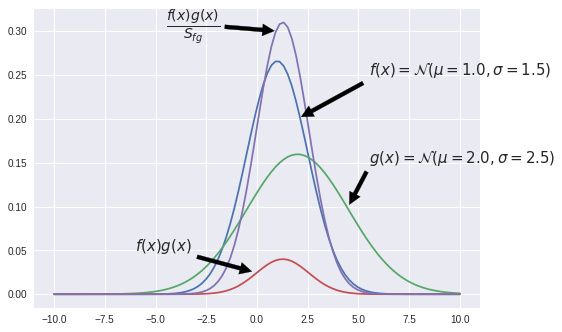

G_f(x)의  -inf~inf 정적분        : 1.000000
G_g(x)의  -inf~inf 정적분        : 1.000000
G_fg(x)의 -inf~inf 정적분        : 0.129019
G_fg(x)의 -inf~inf 정적분 / S_gf : 1.000000


In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib as mpl
mpl.style.use('seaborn')

x = np.linspace(-10, 10, 100)

class Gaussian :
    def __init__(self, mu, sigma, scaled_const=1) :
        """
        정규분포의 파라미터 2개외에 scaled_const를 정의
        scaled_const는 정규화된 경우 1이다.
        """
        self.mu = mu
        self.sigma = sigma
        self.scaled_const = scaled_const
        
    def pdf(self, x):
        return self.scaled_const / (np.sqrt(2*np.pi)*self.sigma) * np.exp( -((x-self.mu)**2)/(2*self.sigma**2) )

    def __mul__(self, other) :
        """
        식(1.3),(1.4),(1.5)을 이용해서 연산자 오버로딩을 한다.
        """
        #eq 1.4
        mu = ((self.mu*(other.sigma**2))+(other.mu*(self.sigma**2))) / (self.sigma**2 + other.sigma**2) 
        
        #eq 1.5
        sigma = np.sqrt( ((self.sigma**2) * (other.sigma**2)) / (self.sigma**2 + other.sigma**2) ) 
        
        #eq 1.3
        S_fg = 1/np.sqrt(2*np.pi*(self.sigma**2 + other.sigma**2))*np.exp(-((self.mu-other.mu)**2)/(2*(self.sigma**2 + other.sigma**2))) 
    
        return Gaussian(mu, sigma, S_fg)
    
g_f  = Gaussian(1.0, 1.5)
g_g  = Gaussian(2.0, 2.5)
g_fg = g_f*g_g

plt.plot(x, g_f.pdf(x), x, g_g.pdf(x), x, g_fg.pdf(x), x, g_fg.pdf(x)/g_fg.scaled_const)
plt.annotate('$f(x)=\mathcal{N}(\mu=1.0, \sigma=1.5)$', xy=(2.0, 0.2), xytext=(5.5, 0.25), fontsize=15, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('$g(x)=\mathcal{N}(\mu=2.0, \sigma=2.5)$', xy=(4.5, 0.1), xytext=(5.5, 0.15), fontsize=15, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('$f(x)g(x)$', xy=(-0.1, 0.025), xytext=(-6, 0.05), fontsize=15, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(r"$\frac{f(x)g(x)}{S_{fg}}$", xy=(1.0, 0.3), xytext=(-4.5, 0.3), fontsize=20, arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

print("G_f(x)의  -inf~inf 정적분        : {:f}".format(integrate.quad(g_f.pdf,  -np.inf, np.inf)[0]))
print("G_g(x)의  -inf~inf 정적분        : {:f}".format(integrate.quad(g_g.pdf,  -np.inf, np.inf)[0]))
print("G_fg(x)의 -inf~inf 정적분        : {:f}".format(integrate.quad(g_fg.pdf, -np.inf, np.inf)[0]))
print("G_fg(x)의 -inf~inf 정적분 / S_gf : {:f}".format(integrate.quad(g_fg.pdf, -np.inf, np.inf)[0]/g_fg.scaled_const))

# 2. 베이즈정리와 정규분포의 곱

<hr/>
<div style="line-height:30px;font-size:15px;">
- 데이터의 분포가 정규분포라고 가정하고 베이즈룰에 따라 데이터에 대한 파라미터의 사후확률을 계산한다.<br/>
- 많은 부분 Conjugate Bayesian analysis of the Gaussian distribution<a href="https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf">[2]</a>를 참고했다.<br/>
- $D$를 $n$개의 관측 데이터, $p(\mu \,|\, \mu_0, \sigma^2_0)$를 파라미터 $\mu$의 사전확률라고 하면 ($\sigma^2$, $\sigma^2_0$ 는 알려진것으로 가정) $\mu$에 대한 사후확률은 다음과 같다.
<br/><br/>
$$
p(\mu \,|\, D) = \frac{p(D \,|\, \mu, \sigma^2) \, p(\mu \,|\, \mu_0, \sigma^2_0)}{p(D)} \tag{2.1}
$$
<br/>

</div>

## 2.1 가능도Likelihood
<hr/>
<div style="line-height:30px;font-size:15px;">
- 관측 데이터를 i.i.d로 가정하면 다음과 같이 가능도 함수는 각 데이터의 확률분포의 곱이다.
<br/><br/>
$$
\begin{align*}
p(D \,|\, \mu, \sigma^2) 
&= \prod_{i = 1}^{n} \left[ \frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left\{ -\frac{1}{2\sigma^2} (x_{i}-\mu)^2 \right\} \right] \\[4pt]
&=  \left( \frac{1}{\sqrt{2\pi \sigma^2}} \right)^{n} \left[ \text{exp}\left\{ -\frac{1}{2\sigma^2} (x_{1}-\mu)^2 \right\}  \text{exp}\left\{ -\frac{1}{2\sigma^2} (x_{2}-\mu)^2 \right\} \cdots \text{exp}\left\{ -\frac{1}{2\sigma^2} (x_{n}-\mu)^2 \right\} \right] \\[4pt]
&=  \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} }  \text{exp}\left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{n}-\mu)^2 \right\}
\end{align*}  \tag{2.2}
$$
<br/>
</div>

## 2.2 사전확률Prior
<hr/>
<div style="line-height:30px;font-size:15px;">
- 공액 사전확률로 정규분포를 파라미터 $\mu$의 사전확률분포로 선택한다.
<br/><br/>
$$
p(\mu \,|\, \mu_0, \sigma^2_0) = \color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } \text{exp} \left\{  -\frac{1}{2\sigma_0^2} (\mu-\mu_0)^2 \right\} \tag{2.3}
$$
<br/>
</div>

## 2.3 가능도 $\times$ 사전확률
<hr/>
<div style="line-height:30px;font-size:15px;">
- 식(2.1)의 분자 계산을 위해 식(2.2)와 식(2.3)을 곱한다.
<br/><br/>
$$
\begin{align}
p(D \,|\, \mu, \sigma^2) p(\mu \,|\, \mu_0, \sigma^2_0) 
&= \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} } \color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } \text{exp}\left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{i}-\mu)^2 \right\}  \text{exp} \left\{  -\frac{1}{2\sigma_0^2} (\mu-\mu_0)^2 \right\}
\end{align} \tag{2.4}
$$
<br/>
- 색깔 부분을 $ C_1 = \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} } \color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } $ 로 두고 계속한다.
<br/><br/>
$$
\begin{align}
p(D \,|\, \mu, \sigma^2) p(\mu \,|\, \mu_0, \sigma^2_0) 
&= \color{DarkOrchid}{ C_1 } \text{exp}\left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{i}-\mu)^2 \right\}  \text{exp} \left\{  -\frac{1}{2\sigma_0^2} (\mu-\mu_0)^2 \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{i}-\mu)^2  -\frac{1}{2\sigma_0^2} (\mu-\mu_0)^2 \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{i}^{2}-2x_{i}\mu + \mu^2)  -\frac{1}{2\sigma_0^2} (\mu^2 - 2\mu_{0}\mu + \mu_{0}^{2}) \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n}x_{i}^{2} +\frac{1}{\sigma^2}\sum_{i=1}^{n}x_{i}\mu - \frac{1}{2\sigma^2}n\mu^2  - \frac{1}{2\sigma_0^2} \mu^2 + \frac{1}{\sigma_0^2}\mu_{0}\mu - \frac{1}{2\sigma_0^2}\mu_{0}^{2} \right\} \\[4pt]
\end{align} \tag{2.5}
$$
<br/>
- $\mu$에 대한 2차식으로 묶으면
<br/><br/>
$$
\begin{align}
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2} \left( \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right) \mu^{2} + \left(\frac{\sum x_{i}}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}  \right) \mu - \left( \frac{\mu_0^{2}}{2\sigma_0^2} + \frac{\sum x_{i}^{2}}{2\sigma^2} \right) \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2} \left( \frac{n}{\sigma^2} + \frac{1}{\sigma_0^2} \right) \mu^{2} + \left(\frac{\sum x_{i}}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}  \right) \mu - \frac{1}{2} \left( \frac{\mu_0^{2}}{\sigma_0^2} - \frac{\sum x_{i}^{2}}{\sigma^2} \right) \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2} \left( \frac{n\sigma_{0}^{2}+\sigma^2}{\sigma^{2}\sigma_{0}^{2}}  \right) \mu^{2} + \left( \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{\sigma^{2}\sigma_{0}^{2}} \right) \mu - \frac{1}{2} \left( \frac{\mu_0^{2}\sigma^{2}-\sigma_{0}^{2}\sum x_{i}^{2}}{\sigma^{2}\sigma_{0}^{2}} \right) \right\} \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left[ -\frac{1}{2} \frac{1}{\sigma^{2}\sigma_{0}^{2}} \left\{ \left( n\sigma_{0}^{2}+\sigma^2 \right) \mu^{2} - 2 \left( \sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2} \right) \mu + \left( \mu_0^{2}\sigma^{2}+\sigma_{0}^{2}\sum x_{i}^{2} \right) \right\} \right] \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left[ -\frac{1}{2} \frac{\left( n\sigma_{0}^{2}+\sigma^2 \right)}{\sigma^{2}\sigma_{0}^{2}} \left\{ \mu^{2} - 2 \left( \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right) \mu + \left( \frac{\sigma_{0}^{2}\sum x_{i}^{2}+\mu_0^{2}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right) \right\} \right] \\[4pt]
\end{align} \tag{2.6}
$$
</div>

<div style="line-height:30px;font-size:15px;">
- { } 부분을 완전제곱형태로 고친다. (completing the square)
<br/><br/>
$$
\begin{align}
&= \color{DarkOrchid}{ C_1 } \text{exp} \left[ -\frac{1}{2} \underbrace{\frac{\left( n\sigma_{0}^{2}+\sigma^2 \right)}{\sigma^{2}\sigma_{0}^{2}}}_{\dfrac{1}{\sigma^{2}_{n}}} \left\{ \left( \mu - \underbrace{\frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2}}_{\mu_{n}} \right)^{2} - \left(\frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2}  + \underbrace{\left( \frac{\sigma_{0}^{2}\sum x_{i}^{2}+\mu_0^{2}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)}_{C_2} \right\} \right] \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left[ -\frac{1}{2} \frac{1}{\sigma^{2}_{n}} \left\{ (\mu-\mu_{n})^{2} - \mu^{2}_{n} + C_2 \right\} \right] \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left[ -\frac{1}{2} \frac{1}{\sigma^{2}_{n}} (\mu-\mu_{n})^{2} + \frac{1}{2} \frac{1}{\sigma^{2}_{n}} \mu^{2}_{n} -\frac{1}{2} \frac{1}{\sigma^{2}_{n}} C_2 \right] \\[4pt]
&= \color{DarkOrchid}{ C_1 } \text{exp} \left\{ -\frac{1}{2} \frac{1}{\sigma^{2}_{n}} (\mu-\mu_{n})^{2} \right\} \text{exp} \left\{ \frac{1}{2} \frac{1}{\sigma^{2}_{n}} \mu^{2}_{n} \right\} \text{exp} \left\{ -\frac{1}{2} \frac{1}{\sigma^{2}_{n}} C_2 \right\}
\end{align} \tag{2.7}
$$
<br/>
- 치환을 원래 모양으로 돌리면
<br/><br/>
$$
\begin{align}
=&\color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} }\color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } 
\text{exp} \left\{ \frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left( \frac{\sigma_{0}^{2} \sum x_{i}+\mu_{0}\sigma^{2}}{n \sigma_{0}^{2} + \sigma^2} \right)^{2} \right\}
\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left( \frac{\sigma_{0}^{2} \sum x_{i}^{2}+ \mu_0^{2}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right) \right\} \\
&\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\} \\[4pt]
= &\color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} }\color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}}  } 
\color{ForestGreen}{ \text{exp} \left\{ \frac{1}{2} \frac{(\sigma_0^2 \sum x_{i} + \mu_{0} \sigma^{2})^{2}}{\sigma^{2}\sigma_{0}^{2}(n\sigma_{0}^{2}+\sigma^2)} \right\} }
\color{Red}{ \text{exp} \left\{ -\frac{1}{2} \left( \frac{\sigma_{0}^{2} \sum x_{i}^{2}+ \mu_0^{2}\sigma^{2}}{\sigma^{2}\sigma_{0}^{2}} \right) \right\} } \\
& \text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\} \\[4pt]
\end{align} \tag{2.8}
$$
<br/>
</div>

<div style="line-height:30px;font-size:15px;">
- 정리하면 사후확률의 분자는 아래와 같다.  
<br/><br/>
$$
\begin{align}
&p(D \,|\, \mu, \sigma^2) p(\mu \,|\, \mu_0, \sigma^2_0) \\
= & \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} }\color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } 
\color{ForestGreen}{ \text{exp} \left\{ \frac{1}{2} \frac{(\sigma_0^2 \sum x_{i} + \mu_{0} \sigma^{2})^{2}}{\sigma^{2}\sigma_{0}^{2}(n\sigma_{0}^{2}+\sigma^2)} \right\} }
\color{Red}{ \text{exp}\left\{ -\frac{1}{2} \frac{\sigma_{0}^{2} \sum x_{i}^{2}+ \mu_0^{2}\sigma^{2} }{\sigma^2\sigma_{0}^{2}} \right\} } \\
& \text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\} 
\end{align} \tag{2.9}
$$
<br/>
- 위 식에서 색깔부분은 모두 상수이고, 식 자체는 사후확률과 비례하므로 사후확률은 평균을
<br/><br/>
$$
\mu_{n}= \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2}
$$
<br/>
로하고 분산제곱의 역수를
<br/><br/>
$$
\frac{1}{\sigma^{2}_{n}} = \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}}
$$
<br/>
로 가지는 정규분포가 된다.<br/>

- 이를 완전히 확인하려면 식(2.1)에서 $p(D)$는 정규화 상수이므로 $p(D)$가 식(2.9)의 색깔있는 부분과 마지막 $\text{exp}(\cdot)$부분의 적분으로 되어있음을 확인하면 된다.

</div>


## 2.3 Marginal Likelihood
<hr/>
<div style="line-height:30px;font-size:15px;">
- 확률의 합법칙은 다음과 같다.
<br/><br/>
$$
P(X) = \sum_{Y} P(X,Y) = \sum_{Y} P(X|Y)P(Y) \tag{2.11}
$$
<br/>
- 연속확률변수에 대해서는 적분으로 바꿔 생각할 수 있고, 가능도를 파라미터 $\mu$에 대해 주변화시키면 아래와 같다.
<br/><br/>
$$
p(D) = \int_{-\infty}^{\infty} \underbrace{P(D \,|\, \mu, \sigma^2)}_{likelihood} \underbrace{P(\mu \,|\, \mu_0, \sigma_0^2)}_{prior} d\mu \tag{2.12}
$$
<br/>
- 식(2.12)를 실제로 적분해서 식(2.9)를 나눠본다.
<br/><br/>
$$
\begin{align}
p(D) &= \int_{-\infty}^{\infty} p(D \,|\, \mu, \sigma^2) p(\mu \,|\, \mu_0, \sigma^2_0) d\mu \\[4pt]
&= \int_{-\infty}^{\infty} \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} } \color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } \text{exp}\left\{ -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_{i}-\mu)^2 \right\}  \text{exp} \left\{  -\frac{1}{2\sigma_0^2} (\mu-\mu_0)^2 \right\} d\mu 
\end{align} \tag{2.13}
$$
<br/>
- 식(2.13)의 피적분 함수Integrand 는 식(2.4)와 같으므로 피적분함수를 2.3절의 과정을 따라 똑같이 정리하면 다음과 같다.
<br/><br/>
$$
\begin{align}
p(D) &= \int_{-\infty}^{\infty} p(D \,|\, \mu, \sigma^2) p(\mu \,|\, \mu_0, \sigma^2_0) d\mu  \\
&= \color{DarkOrchid}{ \frac{1}{\left(\sqrt{2\pi \sigma^2}\right)^{n}} }\color{DarkOrchid}{ \frac{1}{\sqrt{2\pi \sigma_0^2}} } 
\color{ForestGreen}{ \text{exp} \left\{ \frac{1}{2} \frac{(\sigma_0^2 \sum x_{i} + \mu_{0} \sigma^{2})^{2}}{\sigma^{2}\sigma_{0}^{2}(n\sigma_{0}^{2}+\sigma^2)} \right\} }
\color{Red}{ \text{exp}\left\{ -\frac{1}{2} \frac{\sigma_{0}^{2} \sum x_{i}^{2}+ \mu_0^{2}\sigma^{2} }{\sigma^2\sigma_{0}^{2}} \right\} } \\
& \int_{-\infty}^{\infty} \text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\}  d\mu 
\end{align} \tag{2.14}
$$
<br/>
- 결국 색깔 부분은 모두 약분되고 사후확률은 식(2.15)처럼 된다.
<br/><br/>
$$
p(\mu \,|\, D) = \frac{\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\}}
{
\int_{-\infty}^{\infty} \text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\}  d\mu 
}\tag{2.15}
$$
<br/>
- 식(2.15)는 분자를 전영역에서 정적분해서 나눔으로써 분자에 있는 지수함수를 정규화하고 있다. 그래서 $p(\mu \,|\, D)$는 적분이 1이 되는 정규분포가 됨을 알 수 있다.<br/>
- 실제로 적분하기 위해서 지수항을 적분해야하는데 이는 가우스 적분으로 알려져있고 아래와 같다. 극좌표계로 바꿔서 적분하는 부분은 Youtube 강의에서 많이 찾아볼 수 있다. (예 : <a href="https://youtu.be/nqNzKeVCYBU">Evaluation of the Gaussian Integral exp(-x^2) - Cool Math Trick </a>)
<br/><br/>
$$
\int_{-\infty}^{\infty} \text{exp} ( -ax^2 ) dx = \sqrt{\frac{\pi}{a}} \tag{2.16}
$$
<br/>
- 지금 적분해야하는 함수는 $\text{exp} \left\{ -a(x-b)^2 \right\}$ 꼴로 $\text{exp} ( -ax^2 )$가 시프트되어 있으므로 $u = x-b$로 치환하면 $du = dx$이고 결국  
<br/><br/>
$$
\int_{-\infty}^{\infty} \text{exp} \left\{ -a(x-b)^2 \right\} dx = \int_{-\infty}^{\infty} \text{exp} \left\{ -a(u)^2 \right\} du= \sqrt{\frac{\pi}{a}} \tag{2.17}
$$
<br/>
같은 적분결과를 얻을 수 있다. 이 결과를 이용해서 적분해보면
<br/><br/>
$$
\int_{-\infty}^{\infty} \text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\}  d\mu 
= \sqrt{\dfrac{\pi}{\frac{ n\sigma_{0}^{2}+\sigma^2 }{2\sigma^{2}\sigma_{0}^{2}}}}
= \sqrt{{\frac{2\pi\sigma^{2}\sigma_{0}^{2}}{n\sigma_{0}^{2}+\sigma^2}}}
\tag{2.18}
$$
<br/>
- 사후확률을 최종적으로 정리해보면 
<br/><br/>
$$
\begin{align}
p(\mu \,|\, D) &= \frac{\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\}}{\sqrt{\frac{2\pi\sigma^{2}\sigma_{0}^{2}}{n\sigma_{0}^{2}+\sigma^2}}} \\[4pt]
&= \sqrt{\frac{n\sigma_{0}^{2}+\sigma^2}{2\pi\sigma^{2}\sigma_{0}^{2} }}
\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\} \\[4pt]
&= \sqrt{\frac{1}{2\pi}\frac{n\sigma_{0}^{2}+\sigma^2}{\sigma^{2}\sigma_{0}^{2}}}
\text{exp} \left\{ -\frac{1}{2} \frac{ n\sigma_{0}^{2}+\sigma^2 }{\sigma^{2}\sigma_{0}^{2}} \left(\mu- \frac{\sigma_{0}^{2} \sum x_{i} + \mu_{0}\sigma^{2}}{n\sigma_{0}^{2}+\sigma^2} \right)^{2} \right\} \\[4pt]
&= \sqrt{\frac{1}{2\pi \sigma^{2}_{n}}} \text{exp} \left\{ - \frac{1}{2 \sigma^{2}_{n}} \left( \mu - \mu_{n} \right)^{2} \right\}
\end{align}
\tag{2.19}
$$
</div>

# 참고문헌
<hr/>
[1] Products and Convolutions of Gaussian Probability Density Functions, P.A. Bromiley, http://www.tina-vision.net/docs/memos/2003-003.pdf<br/>
[2] Conjugate Bayesian analysis of the Gaussian distribution, Kevin P. Murphy, https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf